<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/C5NP_C5IP_C6IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [0]:
import pandas as pd

train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0).reset_index(drop=True)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)

test_200 = test_250.loc[ test_250.index % 5 != 0 ,:]
test_50 = test_250.loc[ test_250.index % 5 == 0 ,:]

train = train.append(test_200)#加入200筆

print('train',train.shape)
print('test_170',test_170.shape)
print('test_50',test_50.shape)

train (4721, 27)
test_170 (170, 27)
test_50 (50, 27)


In [0]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


In [0]:
features = ['T10','T50','T90','N+A']
y_columns = train.columns.tolist()[4:]
y_name = 'C5NP'

# features scaler

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train[features])

train[features] = scaler.transform(train[features])
test_170[features] = scaler.transform(test_170[features])
test_50[features] = scaler.transform(test_50[features])

# corr with x

In [0]:
corrs = train[features+[y_name]].corr()
abs(corrs)

,T10,T50,T90,N+A,C5NP
T10,1.000000,0.895238,0.222087,0.262210,0.938402
T50,0.895238,1.000000,0.533778,0.371996,0.804852
T90,0.222087,0.533778,1.000000,0.217989,0.140439
N+A,0.262210,0.371996,0.217989,1.000000,0.186861
C5NP,0.938402,0.804852,0.140439,0.186861,1.000000


# corr with y

In [0]:
corrs = train[y_columns].corr()[[y_name]]
abs(corrs).sort_values(by=y_name,ascending=False).head(5)

,C5NP
C5NP,1.000000
C5IP,0.968468
C6IP,0.894477
C9IP,0.740485
C8NP,0.718144


# features selected pca_col selected

In [0]:
features = ['T10']
pca_col = ['C5NP','C5IP','C6IP']

# 特徵工程

In [0]:
pass

# isomape萃取特徵

In [0]:
pass

# PCA y_columns

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()
pca = PCA(n_components=1)

train['pca_1'] = pca.fit_transform(scaler_y.fit_transform(train[pca_col]))
test_170['pca_1'] = pca.transform(scaler_y.transform(test_170[pca_col]))
test_50['pca_1'] = pca.transform(scaler_y.transform(test_50[pca_col]))

# corr with x,y

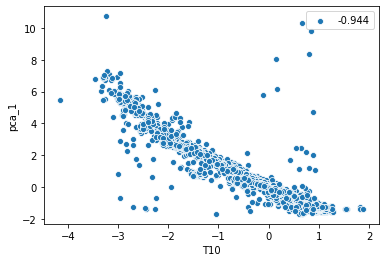

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
labels = train[features+['pca_1']].corr().loc['pca_1',features][0]
labels = round(labels,3)
sns.scatterplot(train[features[0]],train['pca_1'],label=labels)
plt.legend()
plt.show()

# metric

In [0]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt
def metric(y_t,y_p,name):
  res = {'R2':r2_score(y_t,y_p),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error':mean_absolute_error(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

# modeling

In [0]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import warnings 
warnings.simplefilter('ignore')

#算法選擇
#model = LinearRegression()
model = SVR()

#交叉驗證表現
val_scores = cross_validate(model,train[features],train['pca_1'],cv=5)
print('交叉驗證分數:',val_scores['test_score'])
print('交叉驗證分數平均:',val_scores['test_score'].mean())

#fit
model.fit(train[features],train['pca_1'])

#預測
train['y_pred'] = model.predict(train[features])
test_170['y_pred'] = model.predict(test_170[features])
test_50['y_pred'] = model.predict(test_50[features])

交叉驗證分數: [0.91244233 0.73532735 0.94656013 0.90918685 0.91263295]
交叉驗證分數平均: 0.8832299250227044


# 分數

In [0]:
metric(train['pca_1'],train['y_pred'],'train').append(
    metric(test_170['pca_1'],test_170['y_pred'],'test_170')).append(
        metric(test_50['pca_1'],test_50['y_pred'],'test_50'))

,R2,RMSE,mean_absolute_error
train,0.904261,0.521139,0.196029
test_170,0.933774,0.179371,0.119999
test_50,0.907307,0.814987,0.483372


# 還原分數

In [0]:
def inverse_pca_score(df):
  y_pred_all = pd.DataFrame(scaler_y.inverse_transform(pca.inverse_transform(df[['y_pred']])),index=df.index,columns=pca_col)
  y_test_all = df[pca_col]
  table = pd.DataFrame()
  for col in pca_col:
    table = table.append(metric(y_test_all[col],y_pred_all[col],col))
  table.loc['AVG'] = table.mean()
  return table

In [0]:
inverse_pca_score(train)

,R2,RMSE,mean_absolute_error
C5NP,0.898166,0.744715,0.339008
C5IP,0.866876,0.601702,0.283132
C6IP,0.800105,0.828910,0.418226
AVG,0.855049,0.725109,0.346789


In [0]:
inverse_pca_score(test_170)

,R2,RMSE,mean_absolute_error
C5NP,0.858075,0.321947,0.199281
C5IP,0.558559,0.339995,0.225590
C6IP,0.826040,0.435963,0.368790
AVG,0.747558,0.365969,0.264554


In [0]:
inverse_pca_score(test_50)

,R2,RMSE,mean_absolute_error
C5NP,0.890966,1.288146,0.716936
C5IP,0.864770,0.986535,0.681274
C6IP,0.827798,1.107578,0.889970
AVG,0.861178,1.127420,0.762727


# line plot

In [0]:
by_col = 'T10'
train = train.sort_values(by=by_col)
test_170 = test_170.sort_values(by=by_col)
test_50 = test_50.sort_values(by=by_col)

In [0]:
def pred_plot(df,name):
  plt.plot(df[by_col],df['y_pred'],label = name+'_pred')
  plt.scatter(df[by_col],df['pca_1'],label = name+'_data')

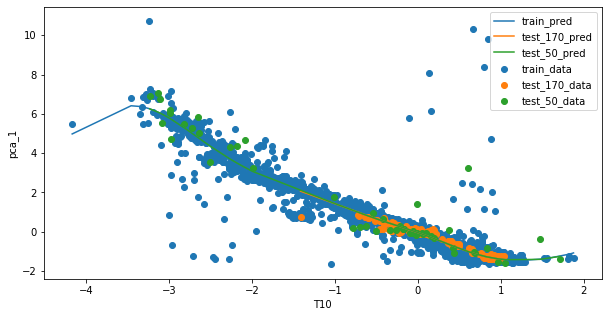

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
pred_plot(train,'train')
pred_plot(test_170,'test_170')
pred_plot(test_50,'test_50')
plt.legend();plt.xlabel(by_col);plt.ylabel('pca_1')
plt.show()

# tag out

In [0]:
def tag_out(df,閥值=10):
  df['out'] = False
  loss = (df['pca_1']-df['y_pred'])**2
  df.loc[list(loss[loss>閥值].index),'out'] = True
  return df

In [0]:
train = tag_out(train)
test_170 = tag_out(test_170)
test_50 = tag_out(test_50)

In [0]:
print(train['out'].value_counts())
print(test_170['out'].value_counts())
print(test_50['out'].value_counts())

False    4698
True       23
Name: out, dtype: int64
False    170
Name: out, dtype: int64
False    49
True      1
Name: out, dtype: int64


# plot out

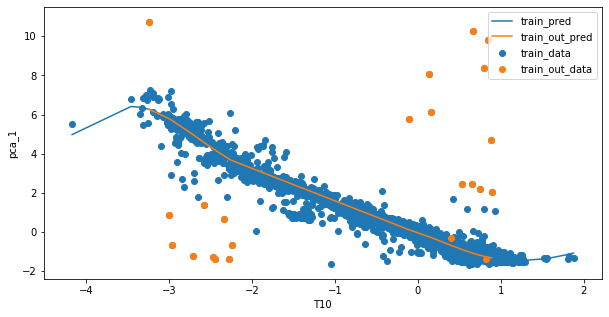

In [0]:
fig = plt.figure(figsize=(10,5))
pred_plot(train,'train')
pred_plot(train[train.out==True],'train_out')
plt.legend();plt.xlabel(by_col);plt.ylabel('pca_1')
plt.show()

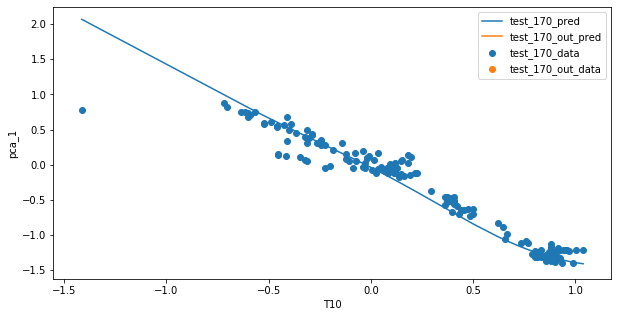

In [0]:
fig = plt.figure(figsize=(10,5))
pred_plot(test_170,'test_170')
pred_plot(test_170[test_170.out==True],'test_170_out')
plt.legend();plt.xlabel(by_col);plt.ylabel('pca_1')
plt.show()

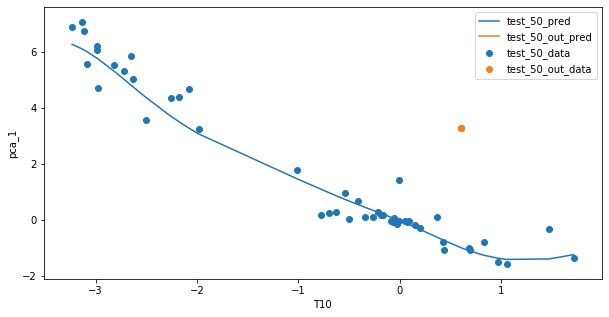

In [0]:
fig = plt.figure(figsize=(10,5))
pred_plot(test_50,'test_50')
pred_plot(test_50[test_50.out==True],'test_50_out')
plt.legend();plt.xlabel(by_col);plt.ylabel('pca_1')
plt.show()

# del out

In [0]:
train = train[train.out==False]
test_170 = test_170[test_170.out==False]
test_50 = test_50[test_50.out==False]

# del out 分數

In [0]:
metric(train['pca_1'],train['y_pred'],'train').append(
    metric(test_170['pca_1'],test_170['y_pred'],'test_170')).append(
        metric(test_50['pca_1'],test_50['y_pred'],'test_50')
    )

,R2,RMSE,mean_absolute_error
train,0.964031,0.313192,0.171109
test_170,0.933774,0.179371,0.119999
test_50,0.957650,0.554491,0.406305


# del out 還原分數

In [0]:
inverse_pca_score(train)

,R2,RMSE,mean_absolute_error
C5NP,0.939806,0.566076,0.310874
C5IP,0.923044,0.448331,0.262401
C6IP,0.905585,0.543344,0.385471
AVG,0.922812,0.519250,0.319582


In [0]:
inverse_pca_score(test_170)

,R2,RMSE,mean_absolute_error
C5NP,0.858075,0.321947,0.199281
C5IP,0.558559,0.339995,0.225590
C6IP,0.826040,0.435963,0.368790
AVG,0.747558,0.365969,0.264554


In [0]:
inverse_pca_score(test_50)

,R2,RMSE,mean_absolute_error
C5NP,0.950811,0.868785,0.593181
C5IP,0.903726,0.839072,0.618369
C6IP,0.873136,0.957890,0.825545
AVG,0.909224,0.888582,0.679032
